In [ ]:
graph()
state
edges
nodes
invoke
stategraph()

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph

class MyState(TypedDict, total=False):
    input: str
    output1: str
    output2: str

def function1(state: MyState) -> dict:
    return {"output1": state["input"] + " from function1"}

def function2(state: MyState) -> dict:
    return {"output2": state["output1"] + " and then function2"}

workflow = StateGraph(MyState)
workflow.add_node("function1", function1)
workflow.add_node("function2", function2)
workflow.add_edge("function1", "function2")
workflow.set_entry_point("function1")
workflow.set_finish_point("function2")
app = workflow.compile()

result = app.invoke({"input": "Hi Anuj"})
print(result)

{'input': 'Hi Anuj', 'output1': 'Hi Anuj from function1', 'output2': 'Hi Anuj from function1 and then function2'}


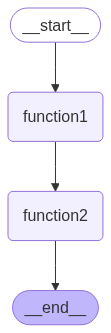

In [99]:
display(Image(app.get_graph().draw_mermaid_png()))

In [101]:
for output in app.stream({"input": "Hi Anuj"}):
    for key,value in output.items():
        print(f"Here is the output from {key}")
        print("___________________________")
        print(value)
        print("\n")

Here is the output from function1
___________________________
{'output1': 'Hi Anuj from function1'}


Here is the output from function2
___________________________
{'output2': 'Hi Anuj from function1 and then function2'}




In [105]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [106]:
model.invoke("hi").content

'Hi there! How can I help you today?'

In [130]:
# State schema
class MyState(TypedDict, total=False):
    input: str
    output: str
    token_count: str

In [131]:
# LLM node
def llm(state: MyState) -> dict:
    model = ChatGoogleGenerativeAI(model='gemini-1.5-flash')
    question = state["input"]
    output = model.invoke(question)
    return {"output": output.content}

# Token counter node
def token_counter(state: MyState) -> dict:
    tokens = state["output"].split()
    token_number = len(tokens)
    return {"token_count": f"Total token number in the generated answer is {token_number}"}


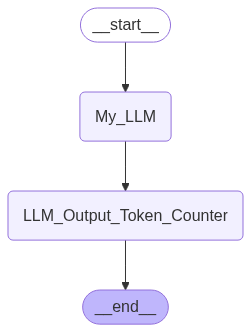

In [132]:
# Build graph
workflow2 = StateGraph(MyState)
workflow2.add_node("My_LLM", llm)
workflow2.add_node("LLM_Output_Token_Counter", token_counter)
workflow2.add_edge("My_LLM", "LLM_Output_Token_Counter")
workflow2.set_entry_point("My_LLM")
workflow2.set_finish_point("LLM_Output_Token_Counter")
display(Image(app.get_graph().draw_mermaid_png()))

In [133]:
# Compile and run
app = workflow2.compile()
result = app.invoke({"input": "What is the capital of India?"})
print(result)

{'input': 'What is the capital of India?', 'output': 'The capital of India is **New Delhi**.', 'token_count': 'Total token number in the generated answer is 7'}


In [135]:
for output in app.stream({"input": "tell me about the tata enterpirse in very detail."}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from My_LLM
_______
{'output': "Tata Enterprises is not a single entity but a massive conglomerate, officially known as the Tata Group.  Understanding it requires looking at its structure, history, key businesses, philosophy, and impact.\n\n**I. History and Structure:**\n\nThe Tata Group's origins trace back to 1868 when Jamsetji Tata founded the Tata & Sons trading company in Bombay (now Mumbai), India.  From humble beginnings in textiles, it diversified aggressively over the decades, driven by a vision of nation-building and social responsibility.  The group's structure is unique:\n\n* **Holding Company:** Tata Sons is the principal investment holding company, owning stakes in various Tata operating companies.  It's not a publicly traded company; its ownership is complex, with trusts playing a significant role in ensuring long-term strategic direction and preventing short-term profit-maximizing decisions.\n* **Operating Companies:**  The group comprises numerous indepe

In [ ]:
# milvus cloud endoint
#https://in03-988dd56ef326f42.serverless.gcp-us-west1.cloud.zilliz.com

In [3]:
import os
import operator
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
milvus_api_key=os.getenv("ZILLIZ_API_KEY")
uri="https://in03-988dd56ef326f42.serverless.gcp-us-west1.cloud.zilliz.com"

In [5]:
milvus_api_key

'afe33d3e68cb9c18a1b7dbfba04257b74fae79d3b268375de13eae61f83e16bae07efa5b18bd595b766a3bc2bf7aeb71a1121b02'

In [1]:
from pymilvus import MilvusClient, DataType

In [6]:
client = MilvusClient(uri=uri, token=milvus_api_key)
print("Connected to Zilliz Cloud successfully!")

Connected to Zilliz Cloud successfully!


In [ ]:
collection_name = "multimodal_collection"

if client.has_collection(collection_name):
    client.drop_collection(collection_name)

schema = client.create_schema(
    auto_id=False,  # We'll provide IDs manually
    enable_dynamic_field=True  # Allows extra fields if needed
)

In [8]:
import os
from pymilvus import MilvusClient
from unstructured.partition.pdf import partition_pdf
from sentence_transformers import SentenceTransformer
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import uuid

/Users/anujpandey/llm_projects/agentic_2.0_projects/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from langchain_community.document_loaders import UnstructuredPDFLoader

In [13]:
text_model = SentenceTransformer('all-mpnet-base-v2')  # 768-dim text embeddings
image_model = SentenceTransformer('clip-ViT-B-32')     # 512-dim image embeddings (CLIP)

In [14]:
# Image preprocessing transform for CLIP
image_transform = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]),
])

In [15]:
uri = uri  # e.g., https://in03-abc123.api.gcp-us-west1.zillizcloud.com
token = milvus_api_key
client = MilvusClient(uri=uri, token=token)
collection_name = "multimodal_collection"

In [21]:
pdf_path = "data/datamgmt.pdf"  # Replace with your PDF path
loader = UnstructuredPDFLoader(
    file_path=pdf_path,
    mode="elements",  # Extract individual elements (text, tables, images)
    strategy="hi_res",  # Use hi_res for better image/table extraction
    extract_images_in_pdf=True,  # Enable image extraction
    infer_table_structure=True,  # Extract table HTML
)
documents = loader.load()

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [18]:
# Step 4: Extract images separately using unstructured.partition_pdf
image_output_dir = "extracted_images"
os.makedirs(image_output_dir, exist_ok=True)
elements = partition_pdf(
    filename=pdf_path,
    strategy="hi_res",
    extract_image_block_types=["Image"],
    extract_image_block_output_dir=image_output_dir,
    extract_image_block_to_payload=False,
    languages=["eng"],
)

KeyboardInterrupt: 